In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from keras.models import load_model

: 

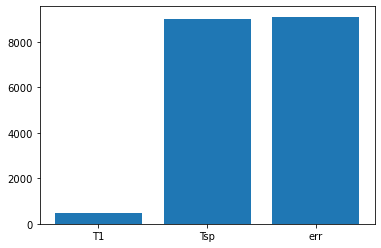

In [2]:
# Load training data
df = pd.read_csv('PID_train_data.csv')

# Create new feature: setpoint error
df['err'] = df['Tsp'] - df['T1']

# Load possible features
X = df[['T1','Tsp','err']]
y = np.ravel(df[['Q1']])

# SelectKBest feature selection
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X,y)
plt.bar(x=X.columns,height=fit.scores_);

In [3]:
# Hyperparameters for model
window = 15
layers = 2
batch_size = 100
drop = 0.1
units = 100

In [4]:
X = df[['Tsp','err']].values
y = df[['Q1']].values

# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)

s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

# Each input uses last 'window' number of Tsp and err to predict the next Q1
X_lstm = []
y_lstm = []
for i in range(window,len(df)):
    X_lstm.append(Xs[i-window:i])
    y_lstm.append(ys[i])

# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_lstm,y_lstm,test_size=0.2,shuffle=False)

In [5]:
Xtrain[0]

array([[0.        , 0.46959005],
       [0.        , 0.46908602],
       [0.        , 0.46690188],
       [0.        , 0.46690188],
       [0.        , 0.46690188],
       [0.        , 0.46690188],
       [0.        , 0.46740591],
       [0.        , 0.46690188],
       [0.        , 0.46908602],
       [0.        , 0.46740591],
       [0.        , 0.46740591],
       [0.        , 0.46740591],
       [0.        , 0.46740591],
       [0.        , 0.46690188],
       [0.        , 0.46807796]])

Epoch 129: early stopping



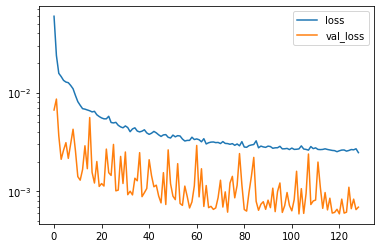

In [6]:
# Keras LSTM model
model = Sequential()

if layers == 1:
    model.add(LSTM(units=units, 
                   input_shape=(Xtrain.shape[1],Xtrain.shape[2])
                  )
             )
    model.add(Dropout(rate=drop))
else:
    # First layer specifies input_shape and returns sequences
    model.add(LSTM(units=units, 
                   return_sequences=True, 
                   input_shape=(Xtrain.shape[1],Xtrain.shape[2])
                  )
             )
    model.add(Dropout(rate=drop))
    # Middle layers return sequences
    for i in range(layers-2):
        model.add(LSTM(units=units,return_sequences=True))
        model.add(Dropout(rate=drop))
    # Last layer doesn't return anything
    model.add(LSTM(units=units))
    model.add(Dropout(rate=drop))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=25
                  )

result = model.fit(Xtrain, ytrain, 
                   verbose=0, 
                   validation_split=0.2,
                   callbacks = [es,TqdmCallback(verbose=1)],
                   batch_size=batch_size,
                   epochs=350)

# Show results and save
epochs = es.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()

model.save('pid_emulate15window.h5')

In [7]:
# Save model parameters
model_params = dict()
model_params['Xscale'] = s_x
model_params['yscale'] = s_y
model_params['window'] = window

pickle.dump(model_params, open('model_params15window.pkl', 'wb'))

34/34 [==============================] - 3s 23ms/step


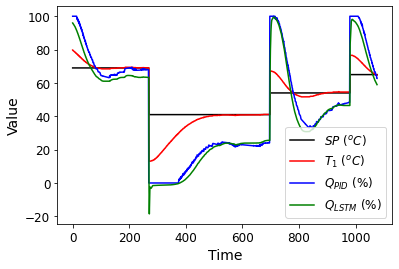

In [8]:
# Predict using LSTM
yp_s = model.predict(Xtest)

# Unscale data
Xtest_us = s_x.inverse_transform(Xtest[:,-1,:])
ytest_us = s_y.inverse_transform(ytest)
yp = s_y.inverse_transform(yp_s)

# Derive Tsp (setpoint) and T1 (sensor) from X data
sp = Xtest_us[:,0]
pv = Xtest_us[:,0] + Xtest_us[:,1]

# Plot SP, PID response, and LSTM response
plt.plot(sp,'k-',label='$SP$ $(^oC)$')
plt.plot(pv,'r-',label='$T_1$ $(^oC)$')
plt.plot(ytest_us,'b-',label='$Q_{PID}$ (%)')
plt.plot(yp,'g-',label='$Q_{LSTM}$ (%)')
plt.legend(fontsize=12,loc='lower right')
plt.xlabel('Time',size=14)
plt.ylabel('Value',size=14)
plt.xticks(size=12)
plt.yticks(size=12);